# Finetuning SAM2 for on Coronary Artery Dataset


In [1]:
# ### For googColab
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import os
# os.getcwd()


### Installing SAM2

In [ ]:
# # Clone the correct repository
# !git clone https://github.com/facebookresearch/segment-anything-2.git

# Change directory
# %cd segment-anything-2

# # Install in editable mode
# !pip install -e .


In [4]:
# %cd D:\ANAND\SAM2_CASBloDAM\SAM2_CASBloDAM
# os.getcwd()

### downloading checkpoint file (Pre-trained_models)

In [5]:
# # Download SAM2 tiny model checkpoint (.pt file)
# # This is the smallest variant suitable for testing and local GPU usage
# !wget -O sam2_hiera_tiny.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt"
# # -O flag: Forces wget to save the downloaded file with the specified name (sam2_hiera_tiny.pt)


In [6]:
## Codes for downloading other model checkpoints

# !wget -O sam2_hiera_tiny.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt"
# !wget -O sam2_hiera_small.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt"
# !wget -O sam2_hiera_base_plus.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt"
# !wget -O sam2_hiera_large.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"

### Imports

In [68]:
import os
import random
import pandas as pd
import cv2
import torch
import torch.nn.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Import tqdm for progress bars

# Import SAM2 modules
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

### Setting the Seed for Reproducibility

For deterministic results and reproducibility, we will set a fixed seed value to ensure consistent runs across different runs. This is a very common strategy for Finetuning SAM2 or any other model

In [2]:
#------ @DEVICE MANAGEMENT ------
# UNCOMMENT the following line to use CUDA device for setting seeds on the device

def set_seeds():
    SEED_VALUE = 42
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    # # For MPS (Metal) device on Mac
    # if torch.backends.mps.is_available():
    #     torch.mps.manual_seed(SEED_VALUE)

    #For CUDA device
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

set_seeds()


In [3]:
# check if cuda is available
torch.cuda.is_available()


True

In [4]:
# # check if mps is available
# torch.backends.mps.is_available()

### Loading and Splitting Dataset

In [5]:
# #@DIRECTORY PATH

            # mac: "/Users/anand/Github_project_portfolio/SAM2_CASBloDaM/Aug_dataset_cor_arteries"
            # workpc: "D:\ANAND\SAM2_CASBloDAM\SAM2_CASBloDAM\Aug_dataset_cor_arteries"   #@path to dataset directory
            #Colab: "/content/drive/MyDrive/Aug_dataset_cor_arteries"
data_dir = "Aug_dataset_cor_arteries"
print(f"data_dir: {data_dir}")

image_dir = os.path.join(data_dir, "Augmented_image")
mask_dir = os.path.join(data_dir, "Augmented_mask")
print(f"image_dir: {image_dir}")
print(f"mask_dir: {mask_dir}")


train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
print("First 5 rows of train_df:")
print(train_df.head())


train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)


def create_data_list(df, image_dir, mask_dir):
    data = []
    for index, row in df.iterrows():
        image_name = row['image_id']
        mask_name = row['mask_id']
        data.append({
            "image": os.path.join(image_dir, image_name),
            "annotation": os.path.join(mask_dir, mask_name)
        })
    return data


train_data = create_data_list(train_df, image_dir, mask_dir)
test_data = create_data_list(test_df, image_dir, mask_dir)

data_dir: Aug_dataset_cor_arteries
image_dir: Aug_dataset_cor_arteries/Augmented_image
mask_dir: Aug_dataset_cor_arteries/Augmented_mask
First 5 rows of train_df:
      image_id      mask_id
0   2_aug2.png   2_aug2.png
1   3_aug2.png   3_aug2.png
2  25_aug3.png  25_aug3.png
3  24_aug3.png  24_aug3.png
4  11_aug1.png  11_aug1.png


### Custom class with functions to create Dataset and then pass it to DataLoader

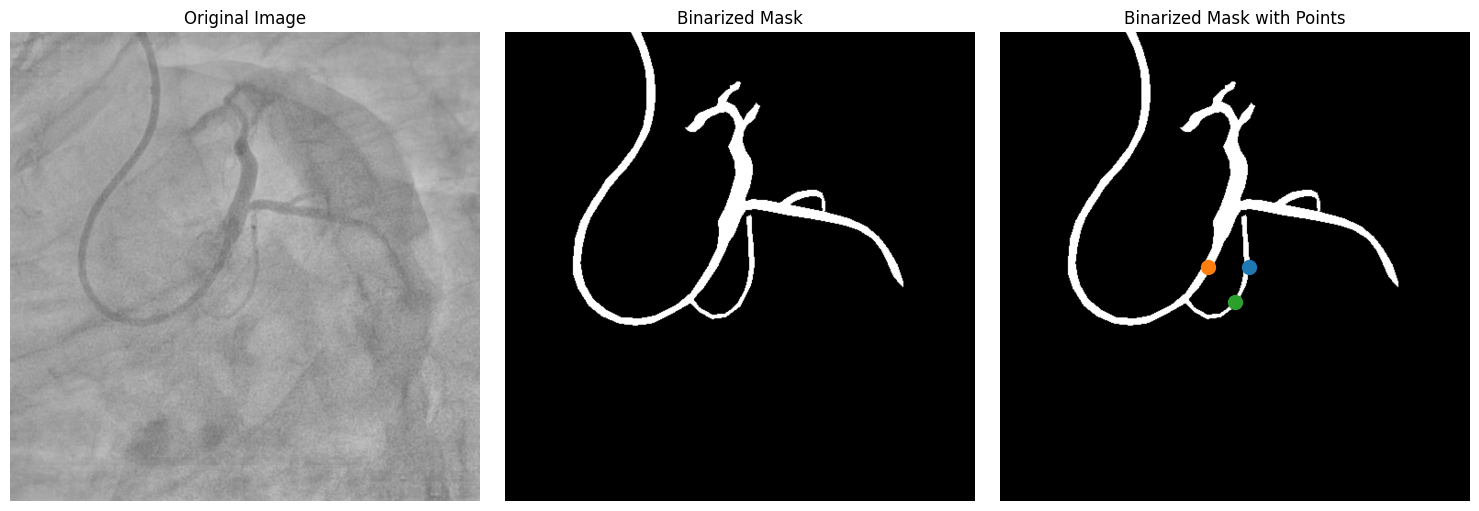

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os


class CoronaryArteryDataset(Dataset):
    def __init__(self, data, transform=None, max_points=3):
        self.data = data
        self.transform = transform
        self.max_points = max_points  # Force each sample to have max_points number of points

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = item['image']
        mask_path = item['annotation']

        # Load image and mask
        Img = cv2.imread(image_path) # Read image without indexing first

        if Img is None: # Check if imread returned None
            raise FileNotFoundError(f"Error: Could not read image file at path: {image_path}. File may be missing, incorrect path, or corrupted.")


        Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB) # Correct color channel conversion

        # Normalize the image to [0, 1] - CORRECTED IMAGE NORMALIZATION
        Img = Img.astype(np.float32) / 255.0


        ann_map = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        ann_map = 255 - ann_map

        # Normalize the mask to [0, 1] - CORRECTED MASK NORMALIZATION
        ann_map = ann_map.astype(np.float32) / 255.0


        # Resize images and masks if needed
        if Img.shape[0] != 1024 or Img.shape[1] != 1024:
            r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])
            Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
            ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)),
                                 interpolation=cv2.INTER_NEAREST)
        else:
            ann_map = cv2.resize(ann_map, (1024, 1024), interpolation=cv2.INTER_NEAREST)

        # Generate points
        binary_mask = np.zeros_like(ann_map, dtype=np.uint8) # Use ann_map which is now normalized
        points_list = [] # Changed variable name to avoid confusion with numpy array 'points'
        inds = np.unique(ann_map)[1:]

        for ind in inds:
            mask = (ann_map == ind).astype(np.uint8) # Use normalized ann_map
            binary_mask = np.maximum(binary_mask, mask)

        center_y, center_x = binary_mask.shape[0] // 2, binary_mask.shape[1] // 2

        def find_nearest_white_pixel(x, y, direction, push_distance=10):
            distance = 0
            while 0 <= x < binary_mask.shape[1] and 0 <= y < binary_mask.shape[0]:
                if binary_mask[y, x] > 0:
                    break
                x += direction[0]
                y += direction[1]
                distance += 1
            else:
                return None, None

            for _ in range(push_distance):
                x += direction[0]
                y += direction[1]
                if not (0 <= x < binary_mask.shape[1] and 0 <= y < binary_mask.shape[0] and binary_mask[y, x] > 0):
                    x -= direction[0]
                    y -= direction[1]
                    break
            return x, y

        directions = [(0, -1), (0, 1), (-1, 0), (1, 0)]
        nearest_points = []

        for direction in directions:
            x, y = center_x, center_y
            nearest_x, nearest_y = find_nearest_white_pixel(x, y, direction)
            if nearest_x is not None and nearest_y is not None:
                nearest_points.append((nearest_x, nearest_y))

        nearest_points.sort(key=lambda p: (p[0] - center_x)**2 + (p[1] - center_y)**2)
        nearest_points = nearest_points[:self.max_points] # Use self.max_points here

        for point in nearest_points:
            points_list.append([point[0], point[1]]) # Append to points_list

        points_np = np.array(points_list) if points_list else np.zeros((0, 2)) # Use points_list

        # Padding to ensure consistent number of points
        if len(points_np) < self.max_points:
            padding_needed = self.max_points - len(points_np)
            padding_array = np.zeros((padding_needed, 2)) # Pad with zeros
            points_np = np.concatenate([points_np, padding_array], axis=0)


        labels = np.ones(len(points_np)) # Labels are now for the padded points as well, but only original points will be relevant in loss
        points_np = np.concatenate([points_np, labels[:, None]], axis=1)
        points = np.expand_dims(points_np, axis=0) # points is now shape (1, max_points, 3)


        # Convert to tensors
        image = torch.tensor(Img.transpose((2, 0, 1)).copy())
        mask = torch.tensor(ann_map, dtype=torch.float32).unsqueeze(0) # Add channel dimension and ensure float32


        return image, mask, points, len(inds)

    def visualize(self, idx):
        image, mask, points, num_masks = self.__getitem__(idx)

        # Display the image and mask with points
        image = image.permute(1, 2, 0).numpy()
        mask_np = mask.squeeze().numpy() # Correctly squeeze mask here
        points = points[0]

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(image)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(mask_np, cmap='gray', vmin=0, vmax=1) # Display mask in grayscale, set vmin and vmax for [0, 1] range
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(mask_np, cmap='gray', vmin=0, vmax=1) # Display mask in grayscale, set vmin and vmax for [0, 1] range
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            if not np.all(point == 0): # Check if point is not a padding zero point
                plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100)
        plt.axis('off')

        plt.tight_layout()
        plt.show()


# Create Dataset instances with max_points set to 3
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor (if needed - not needed here as we are already using numpy and converting to tensor later)
])


train_dataset = CoronaryArteryDataset(train_data, max_points=3)
test_dataset = CoronaryArteryDataset(test_data, max_points=3)

# Visualize an entry
train_dataset.visualize(0)

# Create DataLoaders
BATCH_SIZE = 4  # ------ @BATCH SIZE ------
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## ------- Fine-Tuning Pipeline -----

In [50]:
sam2_checkpoint = "/home/administrator/Dev/Anand/SAM2_CASBloDaM/sam2_hiera_large.pt"
#Colab :  "/content/sam2_hiera_tiny.pt"
# mac: "/Users/anand/Github_project_portfolio/SAM2_CASBloDaM/sam2_hiera_tiny.pt"

model_cfg = "sam2_hiera_l.yaml"
# mac_&_colab: "sam2_hiera_t.yaml"

# Device configuration
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")  #------ @DEVICE MANAGEMENT ------

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device= device)
predictor = SAM2ImagePredictor(sam2_model)

# Enable training for mask decoder and prompt encoder
predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(True)


PromptEncoder(
  (pe_layer): PositionEmbeddingRandom()
  (point_embeddings): ModuleList(
    (0-3): 4 x Embedding(1, 256)
  )
  (not_a_point_embed): Embedding(1, 256)
  (mask_downscaling): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(2, 2))
    (1): LayerNorm2d()
    (2): GELU(approximate='none')
    (3): Conv2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (4): LayerNorm2d()
    (5): GELU(approximate='none')
    (6): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (no_mask_embed): Embedding(1, 256)
)

In [51]:

import torch

# Determine if CUDA (GPU) is available and set the device accordingly
device = "cuda"   #------ @DEVICE MANAGEMENT ------
print(f"Using device: {device}") #Print the used device to ensure the model is initialized on the correct device

# Optimizer and Scheduler
optimizer = torch.optim.AdamW(
    params=predictor.model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

# Switch to ReduceLROnPlateau scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5, # Increased patience for epoch-based scheduling
    min_lr=1e-6
)

# Other hyperparameters
accumulation_steps = 4
NO_OF_EPOCHS = 50  # Define the number of epochs
FINE_TUNED_MODEL_NAME = "cor_fine_tuned_large_sam2"

predictor.model.to(device) # Move your model to the selected device

#Scaler initialization AFTER you’ve moved your model to the GPU.
scaler = torch.amp.GradScaler('cuda')    ## ----- @GRADIENT SCALER Change device !!! ------

Using device: cuda


In [52]:
# ---Training_Func---

def train_epoch(predictor, train_dataloader, epoch, accumulation_steps, optimizer, scaler, device, NO_OF_EPOCHS): # Removed scheduler from arguments
    predictor.model.train()
    total_loss = 0.0
    total_iou = 0.0
    num_batches = len(train_dataloader)
    mean_iou = 0.0

    with tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NO_OF_EPOCHS}", unit="batch") as tepoch:
        for i, (images, masks, points, num_masks) in enumerate(tepoch):
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)
            points = points.to(device)

            # Clear gradients
            if (i + 1) % accumulation_steps == 1:
                optimizer.zero_grad()

            batch_losses = []
            batch_iou_values = []

            for j in range(len(images)):
                with torch.amp.autocast(device_type=device):  # Specifying device_type here
                    # Extract unnorm_coords and labels for this batch item
                    batch_unnorm_coords = points[j, 0, :, :2]
                    batch_labels = points[j, 0, :, 2]
                    batch_unnorm_coords = batch_unnorm_coords.unsqueeze(0)
                    batch_labels = batch_labels.unsqueeze(0)

                    # Convert image to numpy and set the correct format
                    image_numpy = images[j].cpu().numpy().transpose((1, 2, 0))
                    predictor.set_image(image_numpy)

                    sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                        points=(batch_unnorm_coords, batch_labels), boxes=None, masks=None
                    )

                    batched_mode = batch_unnorm_coords.shape[0] > 1
                    high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]

                    low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                        image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                        image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                        sparse_prompt_embeddings=sparse_embeddings,
                        dense_prompt_embeddings=dense_embeddings,
                        multimask_output=True,
                        repeat_image=batched_mode,
                        high_res_features=high_res_features,
                    )

                    prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
                    prd_mask = torch.sigmoid(prd_masks[:, 0])
                    gt_mask = masks[j].unsqueeze(0) # Use original masks for GT


                    # Corrected IOU calculation - using sum over height and width dims
                    inter = (gt_mask * (prd_mask > 0.5)).sum(dim=(-2, -1))
                    union = (gt_mask.sum(dim=(-2, -1)) + (prd_mask > 0.5).sum(dim=(-2, -1)) - inter)
                    iou = inter / (union + 1e-6) # Added small epsilon to avoid division by zero

                    # Corrected Segmentation Loss - ensure proper dimensions
                    seg_loss = (-gt_mask * torch.log(prd_mask + 1e-6) - (1 - gt_mask) * torch.log((1 - prd_mask) + 1e-6)).mean()
                    score_loss = torch.abs(prd_scores[:, 0] - iou).mean() # score_loss remains as is, assuming prd_scores is intended to predict IOU
                    loss = seg_loss + score_loss * 0.05


                    batch_losses.append(loss)
                    batch_iou_values.append(iou)
                    #Debugging for unusual IOU and Loss values
                    # print("--- Debugging IOU Calculation (Train) ---")
                    # print(f"gt_mask min/max: {gt_mask.min().item():.4f}/{gt_mask.max().item():.4f}")
                    # print(f"prd_mask min/max: {prd_mask.min().item():.4f}/{prd_mask.max().item():.4f}")
                    # print(f"inter: {inter.item():.4f}, shape: {inter.shape}")
                    # print(f"union: {union.item():.4f}, shape: {union.shape}")
                    # print(f"iou: {iou.item():.4f}, shape: {iou.shape}")
                    # print("----------------------------------")
                    # print("--- Debugging Loss Calculation (Train) ---")
                    # print(f"seg_loss: {seg_loss.item():.4f}")
                    # print(f"score_loss: {score_loss.item():.4f}")
                    # print(f"loss: {loss.item():.4f}")
                    # print("-----------------------------------")


            # Accumulate batch gradients
            total_loss_batch = sum(batch_losses) / accumulation_steps
            scaler.scale(total_loss_batch).backward()


            if (i + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                # scheduler.step(total_loss_batch) # Removed batch-based scheduler step


            # Corrected IOU calculation for epoch average - stack tensors then calculate mean
            total_iou_batch = torch.stack(batch_iou_values)
            mean_iou += torch.mean(total_iou_batch).item()


            total_loss += sum([l.item() for l in batch_losses])


            tepoch.set_postfix({
                "loss": total_loss / (i + 1), # Display running average loss
                "iou": mean_iou / (i + 1), # Display running average IOU
                "lr": optimizer.param_groups[0]["lr"],
            })

    avg_loss = total_loss / num_batches
    avg_iou = mean_iou / num_batches

    return avg_loss, avg_iou

In [53]:
# --- Validation Func ---

def validate_epoch(predictor, test_dataloader, epoch, device, NO_OF_EPOCHS):
    predictor.model.eval()
    total_loss = 0.0
    total_iou = 0.0
    num_batches = len(test_dataloader)
    mean_iou = 0.0 # Initialize mean_iou for running average

    with torch.no_grad():
        with tqdm(test_dataloader, desc=f"Validation Epoch {epoch+1}/{NO_OF_EPOCHS}", unit="batch") as tepoch:
            for i, (images, masks, points, num_masks) in enumerate(tepoch):
                # Move data to device
                images = images.to(device)
                masks = masks.to(device)
                points = points.to(device)

                batch_losses = []
                batch_iou_values = []

                for j in range(len(images)):
                    # Extract unnorm_coords and labels for this batch item
                    batch_unnorm_coords = points[j, 0, :, :2]
                    batch_labels = points[j, 0, :, 2]
                    batch_unnorm_coords = batch_unnorm_coords.unsqueeze(0)  # Add batch dimension: Shape becomes (1, num_points, 2)
                    batch_labels = batch_labels.unsqueeze(0)  # Add batch dimension: Shape becomes (1, num_points)

                    if batch_unnorm_coords is None or batch_labels is None or batch_unnorm_coords.shape[0] == 0 or batch_labels.shape[1] == 0:
                        tepoch.set_postfix({"message": "Skipping batch due to empty prompts after preparation"})
                        continue

                    # Convert image to numpy and set the correct format
                    image_numpy = images[j].cpu().numpy().transpose((1, 2, 0))

                    predictor.set_image(image_numpy)

                    with torch.amp.autocast(device_type=device):
                        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                            points=(batch_unnorm_coords, batch_labels), boxes=None, masks=None
                        )

                        batched_mode = batch_unnorm_coords.shape[0] > 1
                        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]

                        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                            sparse_prompt_embeddings=sparse_embeddings,
                            dense_prompt_embeddings=dense_embeddings,
                            multimask_output=True,
                            repeat_image=batched_mode,
                            high_res_features=high_res_features,
                        )

                    prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
                    prd_mask = torch.sigmoid(prd_masks[:, 0])

                    # Use original masks for GT
                    gt_mask = masks[j].unsqueeze(0)

                    # Corrected IOU calculation - using sum over height and width dims
                    inter = (gt_mask * (prd_mask > 0.5)).sum(dim=(-2, -1)) # Sum over last two dims (H, W)
                    union = (gt_mask.sum(dim=(-2, -1)) + (prd_mask > 0.5).sum(dim=(-2, -1)) - inter)
                    iou = inter / (union + 1e-6) # Added small epsilon to avoid division by zero


                    seg_loss = (-gt_mask * torch.log(prd_mask + 1e-6) - (1 - gt_mask) * torch.log((1 - prd_mask) + 1e-6)).mean()
                    score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
                    loss = seg_loss + score_loss * 0.05

                    batch_losses.append(loss)
                    batch_iou_values.append(iou)
                    # Debug for unusual IoU and Loss values
                    # print("--- Debugging IOU Calculation (Train) ---")
                    # print(f"gt_mask min/max: {gt_mask.min().item():.4f}/{gt_mask.max().item():.4f}")
                    # print(f"prd_mask min/max: {prd_mask.min().item():.4f}/{prd_mask.max().item():.4f}")
                    # print(f"inter: {inter.item():.4f}, shape: {inter.shape}")
                    # print(f"union: {union.item():.4f}, shape: {union.shape}")
                    # print(f"iou: {iou.item():.4f}, shape: {iou.item():.4f}")
                    # print("----------------------------------")
                    # print("--- Debugging Loss Calculation (Train) ---")
                    # print(f"seg_loss: {seg_loss.item():.4f}")
                    # print(f"score_loss: {score_loss.item():.4f}")
                    # print(f"loss: {loss.item():.4f}")
                    # print("-----------------------------------")

                # Corrected line: Stack tensors directly, then calculate mean
                total_iou_batch = torch.stack(batch_iou_values)
                total_iou += torch.mean(total_iou_batch)


                total_loss += sum([l.item() for l in batch_losses])
                mean_iou += torch.mean(total_iou_batch).item() # Accumulate mean IOU for epoch display


                tepoch.set_postfix({"loss": total_loss / (i + 1), "iou": mean_iou / (i+1)}) # Display running average IOU

    avg_loss = total_loss / num_batches
    avg_iou = mean_iou / num_batches # Final average IOU for epoch
    return avg_loss, avg_iou


In [54]:
# -------Main Training loop-------

train_mean_iou = 0
valid_mean_iou = 0

# ------- History storing -------
training_history = []
validation_history = []

# Define checkpoint saving interval
CHECKPOINT_INTERVAL = 10  # Save model every 10 epochs

for epoch in range(NO_OF_EPOCHS):
    train_loss, train_mean_iou = train_epoch(predictor, train_dataloader, epoch, accumulation_steps, optimizer, scaler, device, NO_OF_EPOCHS) # Removed scheduler from train_epoch call
    valid_loss, valid_mean_iou = validate_epoch(predictor, test_dataloader, epoch, device, NO_OF_EPOCHS)

    # Step the scheduler AFTER validation epoch, using validation loss
    scheduler.step(valid_loss)

    training_history.append({
        "epoch": epoch + 1,
        "loss": train_loss,
        "mean_iou": train_mean_iou
    })

    validation_history.append({
        "epoch": epoch + 1,
        "loss": valid_loss,
        "mean_iou": valid_mean_iou
    })

    print(f"Epoch {epoch+1}/{NO_OF_EPOCHS}:")
    print(f"  Train Loss: {train_loss:.6f}, Train IoU: {train_mean_iou:.6f}")
    print(f"  Validation Loss: {valid_loss:.6f}, Validation IoU: {valid_mean_iou:.6f}")

    # Save model checkpoint every CHECKPOINT_INTERVAL epochs or on the final epoch
    if (epoch + 1) % CHECKPOINT_INTERVAL == 0 or (epoch + 1) == NO_OF_EPOCHS:
        FINE_TUNED_MODEL = f"{FINE_TUNED_MODEL_NAME}_epoch_{epoch+1}.pt"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': predictor.model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': valid_loss,
            'train_iou': train_mean_iou,
            'val_iou': valid_mean_iou,
            'learning_rate': optimizer.param_groups[0]["lr"] # Save current learning rate
        }, FINE_TUNED_MODEL)
        print(f"  Saved checkpoint model to {FINE_TUNED_MODEL}")

print("Training complete!")

Validation Epoch 1/50: 100%|██████████| 16/16 [00:12<00:00,  1.33batch/s, loss=0.378, iou=0.736]


Epoch 1/50:
  Train Loss: 0.819466, Train IoU: 0.560167
  Validation Loss: 0.377599, Validation IoU: 0.735771


Validation Epoch 2/50: 100%|██████████| 16/16 [00:11<00:00,  1.35batch/s, loss=0.359, iou=0.757]


Epoch 2/50:
  Train Loss: 0.395747, Train IoU: 0.730710
  Validation Loss: 0.359128, Validation IoU: 0.756873


Validation Epoch 3/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.33, iou=0.762] 


Epoch 3/50:
  Train Loss: 0.356857, Train IoU: 0.741282
  Validation Loss: 0.329997, Validation IoU: 0.761756


Validation Epoch 4/50: 100%|██████████| 16/16 [00:12<00:00,  1.33batch/s, loss=0.309, iou=0.755]


Epoch 4/50:
  Train Loss: 0.332541, Train IoU: 0.758101
  Validation Loss: 0.308590, Validation IoU: 0.754854


Validation Epoch 5/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.303, iou=0.763]


Epoch 5/50:
  Train Loss: 0.325565, Train IoU: 0.757882
  Validation Loss: 0.302893, Validation IoU: 0.763350


Validation Epoch 6/50: 100%|██████████| 16/16 [00:11<00:00,  1.33batch/s, loss=0.306, iou=0.761]


Epoch 6/50:
  Train Loss: 0.301818, Train IoU: 0.765061
  Validation Loss: 0.305619, Validation IoU: 0.761078


Validation Epoch 7/50: 100%|██████████| 16/16 [00:12<00:00,  1.33batch/s, loss=0.305, iou=0.75] 


Epoch 7/50:
  Train Loss: 0.290754, Train IoU: 0.768169
  Validation Loss: 0.305230, Validation IoU: 0.750112


Validation Epoch 8/50: 100%|██████████| 16/16 [00:12<00:00,  1.33batch/s, loss=0.282, iou=0.77] 


Epoch 8/50:
  Train Loss: 0.282014, Train IoU: 0.773204
  Validation Loss: 0.281743, Validation IoU: 0.769625


Validation Epoch 9/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.273, iou=0.783]


Epoch 9/50:
  Train Loss: 0.274740, Train IoU: 0.778115
  Validation Loss: 0.273149, Validation IoU: 0.782772


Validation Epoch 10/50: 100%|██████████| 16/16 [00:12<00:00,  1.33batch/s, loss=0.278, iou=0.779]


Epoch 10/50:
  Train Loss: 0.263491, Train IoU: 0.784118
  Validation Loss: 0.278370, Validation IoU: 0.779422
  Saved checkpoint model to cor_fine_tuned_large_sam2_epoch_10.pt


Validation Epoch 11/50: 100%|██████████| 16/16 [00:12<00:00,  1.33batch/s, loss=0.277, iou=0.779]


Epoch 11/50:
  Train Loss: 0.253112, Train IoU: 0.790062
  Validation Loss: 0.277027, Validation IoU: 0.778890


Validation Epoch 12/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.3, iou=0.771]  


Epoch 12/50:
  Train Loss: 0.261518, Train IoU: 0.787242
  Validation Loss: 0.299619, Validation IoU: 0.771396


Validation Epoch 13/50: 100%|██████████| 16/16 [00:12<00:00,  1.33batch/s, loss=0.288, iou=0.776]


Epoch 13/50:
  Train Loss: 0.255122, Train IoU: 0.789027
  Validation Loss: 0.288466, Validation IoU: 0.776162


Validation Epoch 14/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.281, iou=0.781]


Epoch 14/50:
  Train Loss: 0.244375, Train IoU: 0.795215
  Validation Loss: 0.281400, Validation IoU: 0.780568


Validation Epoch 15/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.294, iou=0.776]


Epoch 15/50:
  Train Loss: 0.238865, Train IoU: 0.799306
  Validation Loss: 0.294447, Validation IoU: 0.775514


Validation Epoch 16/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.276, iou=0.788]


Epoch 16/50:
  Train Loss: 0.235995, Train IoU: 0.800766
  Validation Loss: 0.275709, Validation IoU: 0.787752


Validation Epoch 17/50: 100%|██████████| 16/16 [00:11<00:00,  1.33batch/s, loss=0.271, iou=0.782]


Epoch 17/50:
  Train Loss: 0.228090, Train IoU: 0.805943
  Validation Loss: 0.270695, Validation IoU: 0.781914


Validation Epoch 18/50: 100%|██████████| 16/16 [00:11<00:00,  1.35batch/s, loss=0.275, iou=0.79] 


Epoch 18/50:
  Train Loss: 0.224771, Train IoU: 0.807446
  Validation Loss: 0.274789, Validation IoU: 0.790373


Validation Epoch 19/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.286, iou=0.779]


Epoch 19/50:
  Train Loss: 0.220944, Train IoU: 0.810425
  Validation Loss: 0.285920, Validation IoU: 0.778831


Validation Epoch 20/50: 100%|██████████| 16/16 [00:12<00:00,  1.33batch/s, loss=0.275, iou=0.788]


Epoch 20/50:
  Train Loss: 0.218487, Train IoU: 0.811660
  Validation Loss: 0.274907, Validation IoU: 0.787711
  Saved checkpoint model to cor_fine_tuned_large_sam2_epoch_20.pt


Validation Epoch 21/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.273, iou=0.786]


Epoch 21/50:
  Train Loss: 0.213624, Train IoU: 0.814896
  Validation Loss: 0.273198, Validation IoU: 0.786439


Validation Epoch 22/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.272, iou=0.791]


Epoch 22/50:
  Train Loss: 0.211127, Train IoU: 0.817456
  Validation Loss: 0.271665, Validation IoU: 0.791308


Validation Epoch 23/50: 100%|██████████| 16/16 [00:11<00:00,  1.33batch/s, loss=0.27, iou=0.791] 


Epoch 23/50:
  Train Loss: 0.209648, Train IoU: 0.818214
  Validation Loss: 0.270425, Validation IoU: 0.791382


Validation Epoch 24/50: 100%|██████████| 16/16 [00:11<00:00,  1.35batch/s, loss=0.279, iou=0.791]


Epoch 24/50:
  Train Loss: 0.206720, Train IoU: 0.820848
  Validation Loss: 0.278919, Validation IoU: 0.790745


Validation Epoch 25/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.289, iou=0.786]


Epoch 25/50:
  Train Loss: 0.207808, Train IoU: 0.820105
  Validation Loss: 0.289399, Validation IoU: 0.786050


Validation Epoch 26/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.277, iou=0.792]


Epoch 26/50:
  Train Loss: 0.205192, Train IoU: 0.822603
  Validation Loss: 0.276548, Validation IoU: 0.792162


Validation Epoch 27/50: 100%|██████████| 16/16 [00:11<00:00,  1.35batch/s, loss=0.285, iou=0.785]


Epoch 27/50:
  Train Loss: 0.205632, Train IoU: 0.820830
  Validation Loss: 0.284513, Validation IoU: 0.784776


Validation Epoch 28/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.288, iou=0.788]


Epoch 28/50:
  Train Loss: 0.202674, Train IoU: 0.822815
  Validation Loss: 0.287547, Validation IoU: 0.788338


Validation Epoch 29/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.281, iou=0.79] 


Epoch 29/50:
  Train Loss: 0.198323, Train IoU: 0.826377
  Validation Loss: 0.280574, Validation IoU: 0.790016


Validation Epoch 30/50: 100%|██████████| 16/16 [00:11<00:00,  1.35batch/s, loss=0.284, iou=0.792]


Epoch 30/50:
  Train Loss: 0.194381, Train IoU: 0.829510
  Validation Loss: 0.284465, Validation IoU: 0.792251
  Saved checkpoint model to cor_fine_tuned_large_sam2_epoch_30.pt


Validation Epoch 31/50: 100%|██████████| 16/16 [00:11<00:00,  1.35batch/s, loss=0.285, iou=0.791]


Epoch 31/50:
  Train Loss: 0.191626, Train IoU: 0.831721
  Validation Loss: 0.284779, Validation IoU: 0.791415


Validation Epoch 32/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.284, iou=0.792]


Epoch 32/50:
  Train Loss: 0.190270, Train IoU: 0.832453
  Validation Loss: 0.284459, Validation IoU: 0.791929


Validation Epoch 33/50: 100%|██████████| 16/16 [00:11<00:00,  1.35batch/s, loss=0.29, iou=0.791] 


Epoch 33/50:
  Train Loss: 0.189428, Train IoU: 0.833270
  Validation Loss: 0.290033, Validation IoU: 0.790710


Validation Epoch 34/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.293, iou=0.788]


Epoch 34/50:
  Train Loss: 0.187866, Train IoU: 0.834233
  Validation Loss: 0.292898, Validation IoU: 0.788434


Validation Epoch 35/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.291, iou=0.791]


Epoch 35/50:
  Train Loss: 0.186510, Train IoU: 0.835224
  Validation Loss: 0.290908, Validation IoU: 0.790892


Validation Epoch 36/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.297, iou=0.79] 


Epoch 36/50:
  Train Loss: 0.184619, Train IoU: 0.836724
  Validation Loss: 0.296712, Validation IoU: 0.789996


Validation Epoch 37/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.298, iou=0.79] 


Epoch 37/50:
  Train Loss: 0.183248, Train IoU: 0.838051
  Validation Loss: 0.297988, Validation IoU: 0.789946


Validation Epoch 38/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.3, iou=0.79]   


Epoch 38/50:
  Train Loss: 0.182280, Train IoU: 0.838780
  Validation Loss: 0.299982, Validation IoU: 0.789742


Validation Epoch 39/50: 100%|██████████| 16/16 [00:12<00:00,  1.33batch/s, loss=0.299, iou=0.791]


Epoch 39/50:
  Train Loss: 0.181586, Train IoU: 0.839238
  Validation Loss: 0.298570, Validation IoU: 0.790893


Validation Epoch 40/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.301, iou=0.79] 


Epoch 40/50:
  Train Loss: 0.180726, Train IoU: 0.839663
  Validation Loss: 0.300781, Validation IoU: 0.789548
  Saved checkpoint model to cor_fine_tuned_large_sam2_epoch_40.pt


Validation Epoch 41/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.302, iou=0.79] 


Epoch 41/50:
  Train Loss: 0.180140, Train IoU: 0.840468
  Validation Loss: 0.301954, Validation IoU: 0.790101


Validation Epoch 42/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.299, iou=0.79] 


Epoch 42/50:
  Train Loss: 0.179205, Train IoU: 0.840594
  Validation Loss: 0.299319, Validation IoU: 0.789926


Validation Epoch 43/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.302, iou=0.79] 


Epoch 43/50:
  Train Loss: 0.178495, Train IoU: 0.841600
  Validation Loss: 0.302327, Validation IoU: 0.789916


Validation Epoch 44/50: 100%|██████████| 16/16 [00:11<00:00,  1.35batch/s, loss=0.303, iou=0.789]


Epoch 44/50:
  Train Loss: 0.177973, Train IoU: 0.841696
  Validation Loss: 0.303337, Validation IoU: 0.789433


Validation Epoch 45/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.303, iou=0.79] 


Epoch 45/50:
  Train Loss: 0.177627, Train IoU: 0.842088
  Validation Loss: 0.302997, Validation IoU: 0.790146


Validation Epoch 46/50: 100%|██████████| 16/16 [00:12<00:00,  1.33batch/s, loss=0.303, iou=0.79] 


Epoch 46/50:
  Train Loss: 0.177144, Train IoU: 0.842297
  Validation Loss: 0.303327, Validation IoU: 0.789642


Validation Epoch 47/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.305, iou=0.79] 


Epoch 47/50:
  Train Loss: 0.176731, Train IoU: 0.842725
  Validation Loss: 0.304536, Validation IoU: 0.790059


Validation Epoch 48/50: 100%|██████████| 16/16 [00:11<00:00,  1.33batch/s, loss=0.305, iou=0.789]


Epoch 48/50:
  Train Loss: 0.176141, Train IoU: 0.842958
  Validation Loss: 0.304878, Validation IoU: 0.789408


Validation Epoch 49/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.306, iou=0.79] 


Epoch 49/50:
  Train Loss: 0.175829, Train IoU: 0.843271
  Validation Loss: 0.306118, Validation IoU: 0.789979


Validation Epoch 50/50: 100%|██████████| 16/16 [00:11<00:00,  1.34batch/s, loss=0.306, iou=0.789]


Epoch 50/50:
  Train Loss: 0.175541, Train IoU: 0.843461
  Validation Loss: 0.305962, Validation IoU: 0.789340
  Saved checkpoint model to cor_fine_tuned_large_sam2_epoch_50.pt
Training complete!


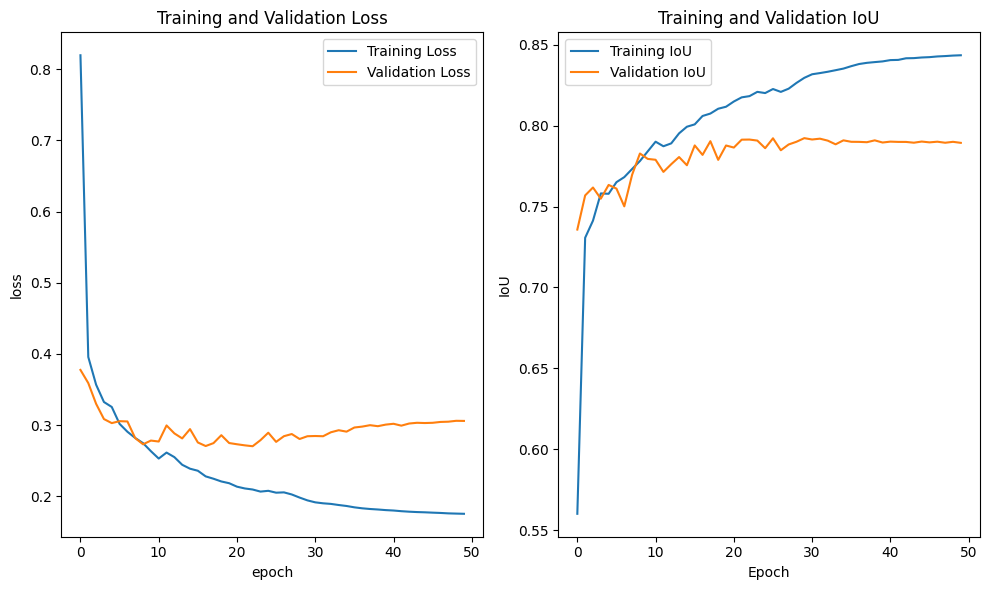

Training complete!


In [55]:
# Convert float32 to regular float before saving
training_history_serializable = []
validation_history_serializable = []

# Convert training history
for epoch_data in training_history:
    serializable_epoch = {
        'epoch': int(epoch_data['epoch']),
        'loss': float(epoch_data['loss']),
        'iou': float(epoch_data['mean_iou'])
    }
    training_history_serializable.append(serializable_epoch)

# Convert validation history
for epoch_data in validation_history:
    serializable_epoch = {
        'epoch': int(epoch_data['epoch']),
        'loss': float(epoch_data['loss']),
        'iou': float(epoch_data['mean_iou'])
    }
    validation_history_serializable.append(serializable_epoch)

# Save to JSON
import json
with open('training_history.json', 'w') as f:
    json.dump(training_history_serializable, f)
with open('validation_history.json', 'w') as f:
    json.dump(validation_history_serializable, f)



# plotting loss
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot([x['loss'] for x in  training_history], label='Training Loss')
plt.plot([x['loss'] for x in  validation_history], label='Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation Loss')
plt.legend()

# plotting IoU
plt.subplot(1, 2, 2)
plt.plot([x['mean_iou'] for x in training_history], label='Training IoU')
plt.plot([x['mean_iou'] for x in validation_history], label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()

plt.tight_layout()
plt.show()


print("Training complete!")

## ----- Inference Pipeline -----

In [64]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)


# Randomly select a test image from the test_data
selected_entry = random.choice(test_data)
print(selected_entry)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']
print(mask_path,'mask path')

# Load the selected image and mask
image, target_mask = read_image(image_path, mask_path)

# Generate random points for the input
num_samples = 30  # Number of points per segment to sample
input_points = get_points(target_mask, num_samples)




{'image': 'Aug_dataset_cor_arteries/Augmented_image/10_aug1.png', 'annotation': 'Aug_dataset_cor_arteries/Augmented_mask/10_aug1.png'}
Aug_dataset_cor_arteries/Augmented_mask/10_aug1.png mask path


In [65]:
# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = "/home/administrator/Dev/Anand/SAM2_CASBloDaM/SAM2_Hiera_l_PEFT_nb/cor_fine_tuned_large_sam2_epoch_50.pt"
# mac : "/Users/anand/Github_project_portfolio/SAM2_CASBloDaM/cor_fine_tuned_tiny_sam2_epoch_39.pt"
# colab: "/content/cor_fine_tuned_tiny_sam2_epoch_39.pt"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)

# Load the state_dict from the checkpoint dictionary
checkpoint = torch.load(FINE_TUNED_MODEL_WEIGHTS) # Load the entire dictionary
predictor.model.load_state_dict(checkpoint['model_state_dict']) # Access 'model_state_dict' key

/tmp/ipykernel_674707/1109071040.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(FINE_TUNED_MODEL_WEIGHTS) # Load the entire dictionary


<All keys matched successfully>

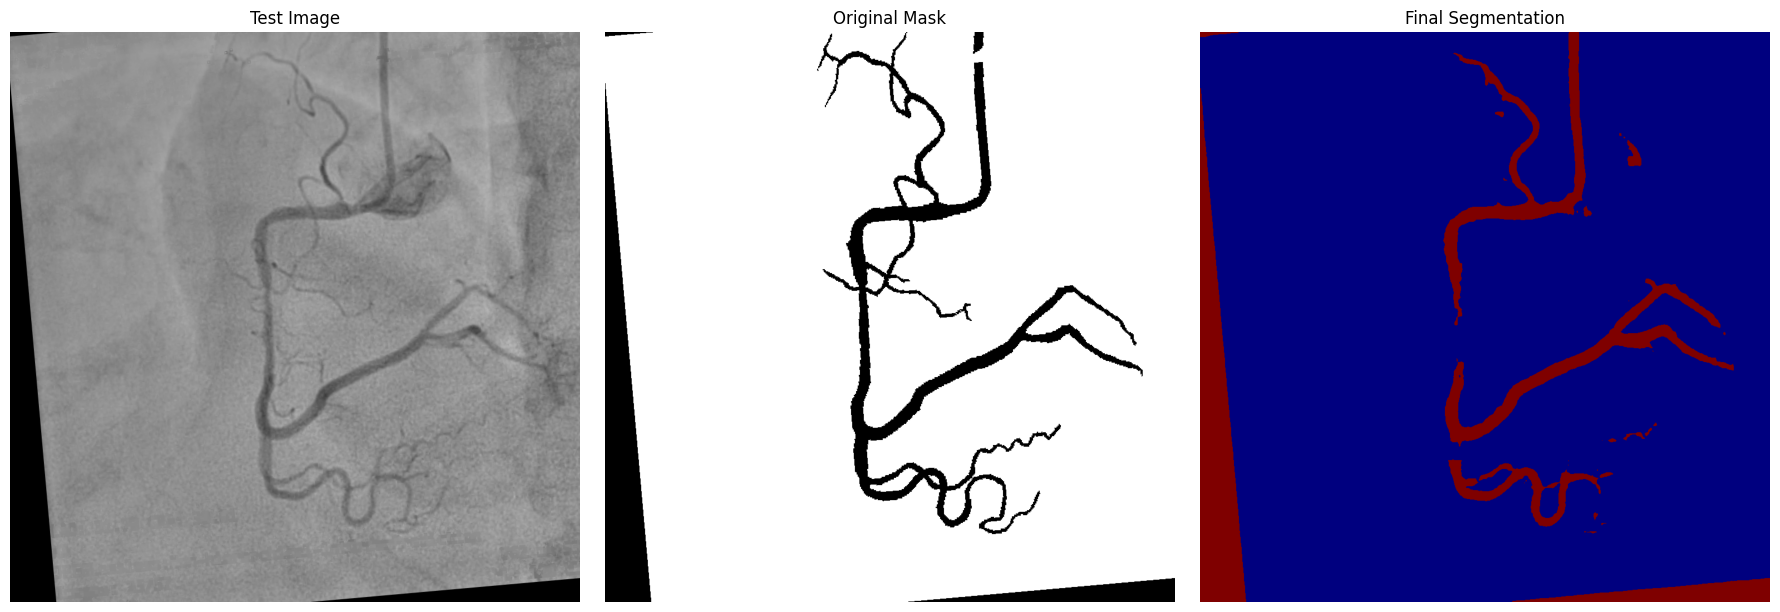

In [66]:

with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

# Visualization: Show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(target_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(seg_map, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()



(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

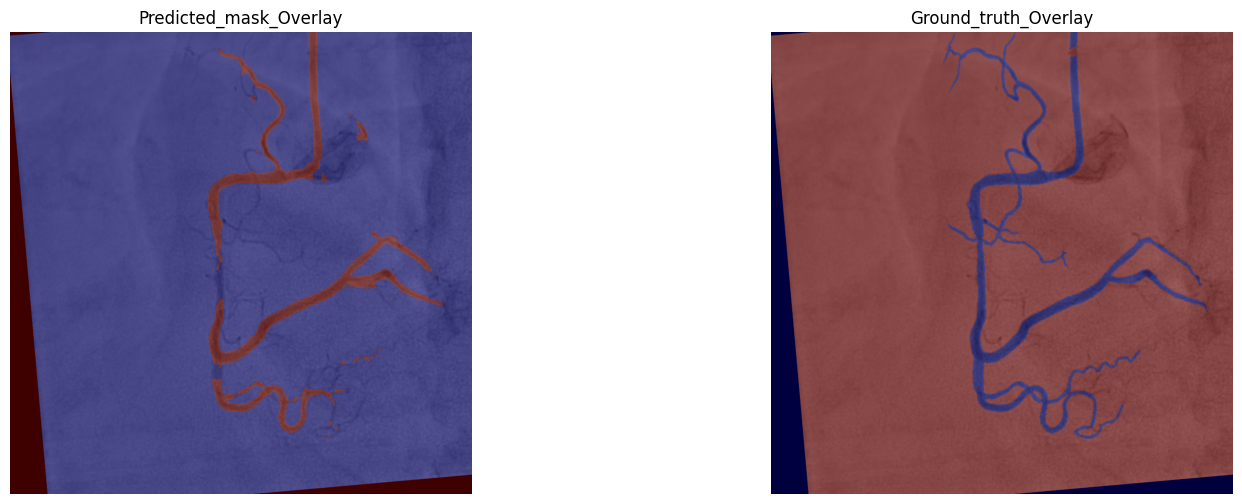

In [67]:


# Visualizaing the Groundtruth_Overlay and Predicted_mask_Overlay

plt.figure(figsize=(18, 6))

plt.subplot(1,2,2)
plt.title("Ground_truth_Overlay")
plt.imshow(image)
plt.imshow(target_mask, alpha=0.5, cmap='jet')
plt.axis('off')

plt.subplot(1,2,1)
plt.title("Predicted_mask_Overlay")
plt.imshow(image)
plt.imshow(seg_map, alpha=0.5, cmap='jet')
plt.axis('off')
